In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import elk
import torch as t
import os
import pandas as pd
import numpy as np
import transformers
from transformers import AutoModelForMaskedLM, AutoTokenizer
from elk.extraction.prompt_dataset import PromptDataset, PromptConfig
from elk.extraction.extraction import ExtractionConfig, extract_hiddens, extract
import yaml

from elk.utils.results import (
    RPATH,
    load_config,
    get_relevant_runs,
    get_eval,
    graph_eval,
    get_reporters,
    model_hidden_states,
    reporter_outputs,
    reporter_output,
    plot_2d_tensor_as_heatmap,
    best_layer_num,
    best_reporter,
    best_layer_output,
    dsget
)

/fsx/home-rudolf/miniconda3/envs/elk4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda"

In [4]:
model_name = "microsoft/deberta-v2-xxlarge-mnli"
dataset_name = "ag_news"
model = AutoModelForMaskedLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at microsoft/deberta-v2-xxlarge-mnli were not used when initializing DebertaV2ForMaskedLM: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing DebertaV2ForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaV2ForMaskedLM were not initialized from the model checkpoint at microsoft/deberta-v2-xxlarge-mnli and are newly initialized: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
You should 

In [5]:
prompt_config = PromptConfig(dataset_name)
dataset = PromptDataset(prompt_config, split="train")

Found cached dataset ag_news (/fsx/home-rudolf/hf_data_cache/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)
100%|██████████| 2/2 [00:00<00:00, 407.27it/s]
Loading cached shuffled indices for dataset at /fsx/home-rudolf/hf_data_cache/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-dd0ff9596fea92b0.arrow


In [6]:
s = set()
for i in range(len(dataset)):
    s.add(dataset[i][0].label)

In [7]:
s

{0, 1}

In [8]:
dsget(dataset, 0)

('What label best describes this news article?\nBangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.\nWorld politics',
 'What label best describes this news article?\nBangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.\nBusiness')

In [9]:
RPATH = "/fsx/home-rudolf/elk-reporters"

In [10]:
runs = get_relevant_runs(
    {
        "data.prompts.dataset": dataset_name,
        "net.net_name": "eigen",
        "data.model": model_name
    }
)

In [11]:
runs

['xenodochial-montalcini',
 'infallible-brown',
 'priceless-bouman',
 'deberta_ag',
 'sad-yonath']

## Initial experiments

In [138]:
# run = runs[-1]
run = "deberta_ag"

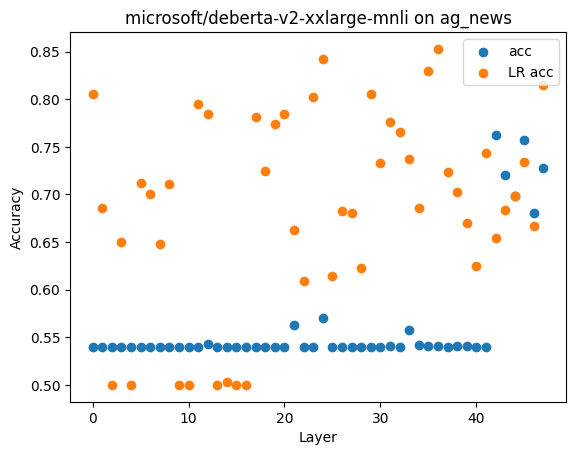

In [139]:
graph_eval(run)

In [140]:
# reporters = get_reporters(run)

In [141]:
# reporters[0]

In [142]:
tokens = tokenizer("This is a test", return_tensors="pt").input_ids.to(device)

In [143]:
outo = model(tokens, output_hidden_states=True)

In [144]:
len(outo[1])

49

In [145]:
get_eval(run)

,layer,pseudo_auroc,train_loss,acc,cal_acc,auroc,ece,lr_auroc,lr_acc
0,0,0.5,-7.3196,0.5400,0.5138,0.5383,0.6497,0.8857,0.8056
1,1,0.5,-0.0101,0.5400,0.5050,0.5210,0.6505,0.7591,0.6856
2,2,0.5,-0.0011,0.5400,0.5138,0.5201,0.6508,0.5081,0.5000
3,3,0.5,-0.0027,0.5400,0.5275,0.5309,0.6506,0.7095,0.6497
4,4,0.5,-0.0009,0.5400,0.5425,0.5394,0.6500,0.5746,0.5000
5,5,0.5,-0.0039,0.5400,0.5288,0.5200,0.6502,0.7803,0.7122
6,6,0.5,-0.0028,0.5400,0.5362,0.5535,0.6474,0.7649,0.7009
7,7,0.5,-0.0012,0.5400,0.5325,0.5254,0.6499,0.7029,0.6478
8,8,0.5,-0.0085,0.5400,0.5163,0.5244,0.6505,0.7836,0.7109
9,9,0.5,-0.0005,0.5400,0.5438,0.5376,0.4598,0.5003,0.5000


In [146]:
best_layer_num(run)

42

In [147]:
best_layer_output(model, tokenizer, run, "Is 1+1=2? Yes")

tensor([ 14.2536, -42.6632,   6.7614, -27.3918, -95.3328, -52.7720, -40.0894,
         78.2191, -10.8344], device='cuda:0', grad_fn=<SelectBackward0>)

In [148]:
best_layer_output(model, tokenizer, run, "Is 1+1=2? No")

tensor([ 14.2702, -23.1251,  10.0365, -25.1719, -98.6346, -48.8217,  18.0221,
         34.5892,  17.7310], device='cuda:0', grad_fn=<SelectBackward0>)

In [165]:
layer = best_layer_num(run)

In [166]:
run

'deberta_ag'

In [167]:
layer

42

## Reporter scale investigation

In [188]:
load_config("sad-yonath")

{'data': {'layers': [],
  'model': 'microsoft/deberta-v2-xxlarge-mnli',
  'prompts': {'balance': False,
   'data_dir': None,
   'dataset': 'ag_news',
   'label_column': None,
   'max_examples': [5000, 5000],
   'num_classes': None,
   'num_shots': 0,
   'num_variants': 1,
   'seed': 42},
  'token_loc': 'last'},
 'debug': False,
 'max_gpus': -1,
 'net': {'inv_weight': 0.0,
  'neg_cov_weight': 1.0,
  'net_name': 'eigen',
  'num_heads': 1,
  'seed': 1,
  'var_weight': 1.0},
 'normalization': 'meanonly',
 'optim': {'lr': 0.01,
  'num_epochs': 1000,
  'num_tries': 10,
  'optimizer': 'lbfgs',
  'weight_decay': 0.01},
 'skip_baseline': False}

In [192]:
scales = [reporter.scale.detach().item() for reporter in get_reporters("sad-yonath")]

In [193]:
csv = get_eval("sad-yonath")

In [198]:
csv

,layer,pseudo_auroc,train_loss,acc,cal_acc,auroc,ece,lr_auroc,lr_acc
0,0,0.5,-7.0464,0.5312,0.5016,0.5093,0.7079,0.8980,0.8213
1,1,0.5,-0.0098,0.5312,0.5008,0.5081,0.7082,0.7566,0.6902
2,2,0.5,-0.0010,0.5314,0.5004,0.5066,0.7088,0.6030,0.5726
3,3,0.5,-0.0025,0.5312,0.5072,0.5038,0.7084,0.7035,0.6530
4,4,0.5,-0.0009,0.5312,0.5096,0.5045,0.7083,0.6593,0.6122
5,5,0.5,-0.0037,0.5312,0.5076,0.5103,0.7076,0.7786,0.7109
6,6,0.5,-0.0027,0.5312,0.5128,0.5203,0.7076,0.7624,0.6946
7,7,0.5,-0.0012,0.5312,0.5084,0.5001,0.5314,0.7262,0.6687
8,8,0.5,-0.0081,0.5312,0.5004,0.5068,0.7084,0.7841,0.7155
9,9,0.5,-0.0004,0.5312,0.5032,0.5016,0.5312,0.6412,0.6015


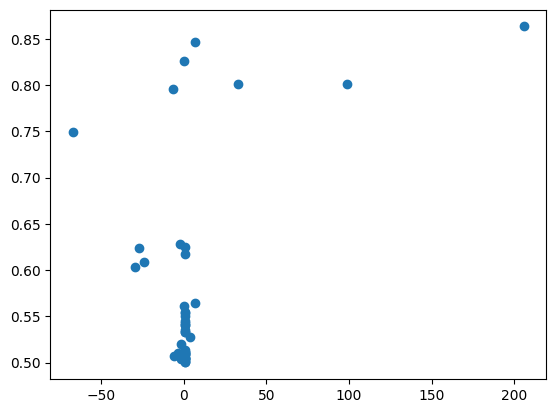

In [197]:
plt.scatter(scales, list(csv["auroc"]))

## Testing accuracy -- manual method

In [12]:
from elk.utils.results import dsgets, reporter_predictions

In [25]:
reporter = best_reporter("deberta_ag")
layer = best_layer_num("deberta_ag")
contrast_pairs = dsgets(dataset, 40)

In [29]:
preds = reporter_predictions(reporter, model, tokenizer, contrast_pairs, layer)

In [35]:
(preds > 0.0).sum() / len(contrast_pairs)

tensor(0.3000)

(array([ 5.,  5., 11.,  7.,  6.,  0.,  3.,  0.,  1.,  2.]),
 array([-1.61437607, -1.20533981, -0.79630356, -0.3872673 ,  0.02176895,
         0.43080521,  0.83984146,  1.24887772,  1.65791397,  2.06695023,
         2.47598648]),
 <BarContainer object of 10 artists>)

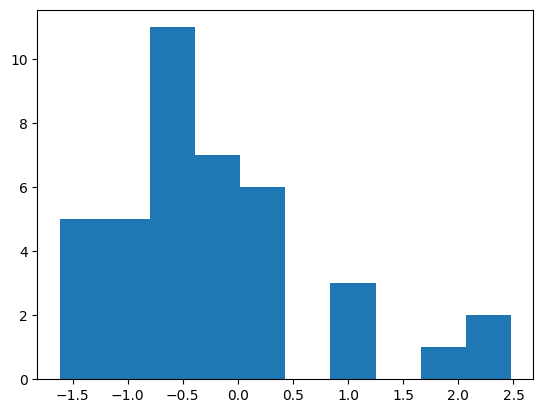

In [28]:
plt.hist(preds)

## Testing with CRC-TRP trained probe

In [149]:
reporter = best_reporter(run)

In [150]:
reporter.scale

Parameter containing:
tensor([167.5063], device='cuda:0', requires_grad=True)

In [151]:
reporter.bias

Parameter containing:
tensor([0.], device='cuda:0', requires_grad=True)

In [182]:
dsget(dataset, 3)

('What label best describes this news article?\nU2 pitches for Apple New iTunes ads airing during baseball games Tuesday will feature the advertising-shy Irish rockers.\nScience and technology',
 'What label best describes this news article?\nU2 pitches for Apple New iTunes ads airing during baseball games Tuesday will feature the advertising-shy Irish rockers.\nWorld politics')

In [164]:
s_pos = "Is 1+1=2? Yes"
s_neg = "Is 1+1=2? No"
pos = tokenizer(s_pos, return_tensors="pt").to(device)["input_ids"]
neg = tokenizer(s_neg, return_tensors="pt").to(device)["input_ids"]

In [176]:
state_pos = model_hidden_states(model, tokenizer, s_pos, layer=layer, tokens="last")
state_neg = model_hidden_states(model, tokenizer, s_neg, layer=layer, tokens="last")

In [177]:
state_pos.shape

torch.Size([1, 1536])

In [178]:
reporter(state_pos)

tensor([-66.4150], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [179]:
reporter(state_neg)

tensor([-65.2467], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [180]:
reporter.predict(state_pos, state_neg)

tensor([-0.5842], device='cuda:0', grad_fn=<MulBackward0>)

In [80]:
# plot_2d_tensor_as_heatmap(reporter_outputs(reporters, "Is 1 + 1 = 2? No"))

## Sanity test for reporter - using existing code

In [88]:
best_layer_num(run)

31

In [89]:
load_config(run)

{'data': {'layers': [],
  'model': 'microsoft/deberta-v2-xxlarge-mnli',
  'prompts': {'balance': False,
   'data_dir': None,
   'dataset': 'ag_news',
   'label_column': None,
   'max_examples': [750, 250],
   'num_classes': None,
   'num_shots': 0,
   'num_variants': -1,
   'seed': 42},
  'token_loc': 'last'},
 'debug': False,
 'max_gpus': -1,
 'net': {'inv_weight': 5.0,
  'neg_cov_weight': 5.0,
  'net_name': 'eigen',
  'num_heads': 1,
  'seed': 999,
  'var_weight': 1.0},
 'normalization': 'meanonly',
 'optim': {'lr': 0.01,
  'num_epochs': 1000,
  'num_tries': 10,
  'optimizer': 'lbfgs',
  'weight_decay': 0.01},
 'skip_baseline': False}

In [116]:
from elk.evaluation.evaluate import (
    evaluate_reporter,
    EvaluateConfig,
    evaluate_reporters
)

from elk.extraction.extraction import (
    extract_hiddens
)

prompt_config2 = PromptConfig(dataset_name)
extract_config = ExtractionConfig(prompt_config2, model_name)
eval_config = EvaluateConfig(
    extract_config,
    run,
    max_gpus=1
)



In [121]:
exgen = extract_hiddens(extract_config, split="train")

In [123]:
x = next(exgen)

In [128]:
list(x.keys())

['label',
 'variant_ids',
 'text_inputs',
 'hidden_0',
 'hidden_1',
 'hidden_2',
 'hidden_3',
 'hidden_4',
 'hidden_5',
 'hidden_6',
 'hidden_7',
 'hidden_8',
 'hidden_9',
 'hidden_10',
 'hidden_11',
 'hidden_12',
 'hidden_13',
 'hidden_14',
 'hidden_15',
 'hidden_16',
 'hidden_17',
 'hidden_18',
 'hidden_19',
 'hidden_20',
 'hidden_21',
 'hidden_22',
 'hidden_23',
 'hidden_24',
 'hidden_25',
 'hidden_26',
 'hidden_27',
 'hidden_28',
 'hidden_29',
 'hidden_30',
 'hidden_31',
 'hidden_32',
 'hidden_33',
 'hidden_34',
 'hidden_35',
 'hidden_36',
 'hidden_37',
 'hidden_38',
 'hidden_39',
 'hidden_40',
 'hidden_41',
 'hidden_42',
 'hidden_43',
 'hidden_44',
 'hidden_45',
 'hidden_46',
 'hidden_47']

In [126]:
len(x["text_inputs"])

15

In [90]:
# ds = extract(eval_config)

AttributeError: 'EvaluateConfig' object has no attribute 'model'

In [85]:
eval_config.target

ExtractionConfig(prompts=PromptConfig(dataset='ag_news', balance=False, data_dir=None, label_column=None, num_classes=None, max_examples=[750, 250], num_shots=0, num_variants=-1, seed=42), model='microsoft/deberta-v2-xxlarge-mnli', layers=(), token_loc='last')

In [ ]:
evaluate_reporters(
    eval_config,
    dataset,
    45,
    devices=[0]
)

AttributeError: 'PromptDataset' object has no attribute 'formatted_as'

### Trying to mimic reporter evaluation code

In [92]:
reporter = best_reporter(run)

In [100]:
layer = best_layer_num(run)
print(layer)

31


In [93]:
reporter.eval()

EigenReporter()

In [108]:
true, false = dsget(dataset, 0)
label = 0
x_pos = model_hidden_states(
    model, tokenizer, true, layer=layer, tokens="last"
)
x_neg = model_hidden_states(
    model, tokenizer, false, layer=layer, tokens="last"
)

In [109]:
x_pos.shape

torch.Size([1, 1536])

In [110]:
x_neg.shape

torch.Size([1, 1536])

In [114]:
reporter.score(t.tensor([[label]]), x_pos, x_neg)

IndexError: tuple index out of range

### reporter.predict()

In [135]:
load_config(run)

{'data': {'layers': [],
  'model': 'microsoft/deberta-v2-xxlarge-mnli',
  'prompts': {'balance': False,
   'data_dir': None,
   'dataset': 'ag_news',
   'label_column': None,
   'max_examples': [750, 250],
   'num_classes': None,
   'num_shots': 0,
   'num_variants': -1,
   'seed': 42},
  'token_loc': 'last'},
 'debug': False,
 'max_gpus': -1,
 'net': {'inv_weight': 5.0,
  'neg_cov_weight': 5.0,
  'net_name': 'eigen',
  'num_heads': 1,
  'seed': 999,
  'var_weight': 1.0},
 'normalization': 'meanonly',
 'optim': {'lr': 0.01,
  'num_epochs': 1000,
  'num_tries': 10,
  'optimizer': 'lbfgs',
  'weight_decay': 0.01},
 'skip_baseline': False}

In [134]:
reporter.predict(x_pos, x_neg)

tensor([-0.5931], device='cuda:0', grad_fn=<MulBackward0>)

In [131]:
reporter.scale

Parameter containing:
tensor([265.3479], device='cuda:0', requires_grad=True)

In [133]:
reporter.bias

Parameter containing:
tensor([0.], device='cuda:0', requires_grad=True)

## Sanity test for reporter - manually running reporter on arbitrary sentence

In [ ]:
def contrast_pair_activations(reporter, dataset, num_examples=10):    
    true_activations = []
    false_activations = []
    for i in range(num_examples):
        (true, false) = dsget(dataset, i)
        true_activations.append(reporter_output(reporter, true).cpu().detach().numpy())
        false_activations.append(reporter_output(reporter, false).cpu().detach().numpy())
    return (true_activations, false_activations)

def ccs_pair_stats(reporter, dataset, num_examples=10):
    true_acts, false_acts = contrast_pair_activations(reporter, dataset, num_examples)
    true_avgs = sum([np.mean(x) for x in true_acts]) / len(true_acts)
    false_avgs = sum([np.mean(x) for x in false_acts]) / len(false_acts)
    true_i_avgs = []
    false_i_avgs = []
    avg_diffs = []
    for i in range(5):
        true_tokens = np.array([x[-i] for x in true_acts])
        false_tokens = np.array([x[-i] for x in false_acts])
        true_i_avgs.append(true_tokens.sum() / true_tokens.shape[0])
        false_i_avgs.append(false_tokens.sum() / false_tokens.shape[0])
        avg_diffs.append((true_tokens - false_tokens).mean())
    return {
        "all": {
            "true_avg": true_avgs,
            "false_avg": false_avgs
        },
        "last_tokens" : {
            i : {
                "true_avg": true_i_avgs[i],
                "false_avg": false_i_avgs[i],
                "avg_diff": avg_diffs[i]
            } for i in range(len(true_i_avgs))
        }
    }

def plot_ccs_pairs(reporter, dataset, num_examples=10):
    true_activations, false_activations = contrast_pair_activations(reporter, dataset, num_examples)
    fig, ax = plt.subplots()
    for x in true_activations:
        ax.scatter(np.linspace(0, 1, x.shape[0]), x, color="green", alpha=0.2)
    for x in false_activations:
        ax.scatter(np.linspace(0, 1, x.shape[0]), x, color="red", alpha=0.2)
    fig.show()

In [ ]:
ccs_pair_stats(best_reporter(run), dataset, num_examples=100)

{'all': {'true_avg': 56.80379832625389, 'false_avg': 56.47858673870564},
 'last_tokens': {0: {'true_avg': 31.5162646484375,
   'false_avg': 31.36864990234375,
   'avg_diff': 0.1476122},
  1: {'true_avg': -67.3269970703125,
   'false_avg': -70.7493017578125,
   'avg_diff': 3.4223},
  2: {'true_avg': 63.3790966796875,
   'false_avg': 87.57171875,
   'avg_diff': -24.192621},
  3: {'true_avg': 73.75615234375,
   'false_avg': 89.436142578125,
   'avg_diff': -15.679998},
  4: {'true_avg': 65.9326708984375,
   'false_avg': 35.6895849609375,
   'avg_diff': 30.24308}}}

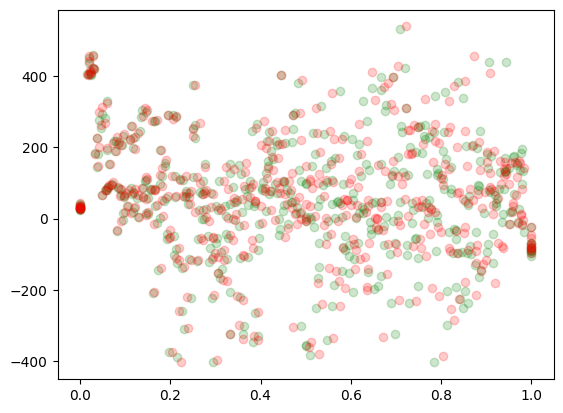

: 

In [ ]:
plot_ccs_pairs(best_reporter(run), dataset)